# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Clustering




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 2 is due February 20th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- Problem 1 + Problem 2 = 75 points ; Problem 3 = 25 points
- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans
from gap_statistic import OptimalK
#from sklearn.datasets.samples_generator import make_blobs


<hr style="height:2pt">

<div class="theme">*Handy* Algorithms </div>


    
In this assignment, you will be working with data collected from a motion capture camera system. The system was used to record 14 different users performing 5 distinct hand postures with markers attached to a left-handed glove. A set of markers on the back of the glove was used to establish a local coordinate system for the hand, and 8 additional markers were attached to the thumb and fingers of the glove. A total of 24 features were collected based on observations from the camera system. Two other variables in the dataset were the ID of the user and the posture that the user made.

These data have been preprocessed, including transformation to the local coordinate system of the record, removal of outliers, and removal of missing data.

The dataset `postures_clean.csv` contains 38,943 rows and 26 columns. Each row corresponds to a single frame as captured by the camera system. The data are represented in the following manner:

`Class (type: Integer). The hand posture of the given observation, with`

`1 = Fist (with thumb out)`

`2 = Stop (hand flat)`

`3 = Point1 (point with index finger)`

`4 = Point2 (point with index and middle fingers)`

`5 = Grab (fingers curled as if to grab)`

`User (type: Integer). The ID of the user that contributed the record.`

`X0, Y0, Z0, X1, Y1, Z1,..., X7, Y7, Z7 (type: Real). The x-coordinate, y-coordinate, and z-coordinate of the eight unlabeled marker positions.`


Start by reading the dataset into a pandas data frame.

In [3]:
#your code here

postures = pd.read_csv('./data/postures_clean.csv')
print('Data Size = {}\n'.format(postures.shape))
print("Is there any missing data? {}\n".format(postures.isna().any().any()))
print("Number of Classes = {}\n".format(postures.Class.nunique()))
print("Number of Users = {}\n".format(postures.User.nunique()))
display(postures.groupby('Class').X0.count())
display(postures.groupby('User').X0.count())
display(postures.groupby(['User', 'Class']).X0.count().unstack(fill_value=0))

Data Size = (38943, 26)

Is there any missing data? False

Number of Classes = 5

Number of Users = 14



Class
1       52
2    14668
3     3556
4     5767
5    14900
Name: X0, dtype: int64

User
0     3641
1     2381
2     1917
4       75
5     3299
6     2860
7      150
8     2746
9     3262
10    4389
11    3777
12    1860
13    3141
14    5445
Name: X0, dtype: int64

Class,1,2,3,4,5
User,,,,,
0,3,1501,162,25,1950
1,0,754,0,558,1069
2,0,808,0,0,1109
4,0,54,1,20,0
5,0,1143,0,973,1183
6,0,962,4,744,1150
7,1,91,16,42,0
8,0,1392,0,474,880
9,0,917,675,832,838


<div class='exercise'>Problem 1: Clustering with k-means </div>

(a) After appropriate pre-processing (but not scaling) run the k-means clustering algorithm, using the `KMeans` class from sklearn.cluster, with the number of clusters corresponding to the number of users, `n_init` of 46, and 109 as the random seed. Add the result as a new column called `Cluster14` to your data frame.

In [4]:
from sklearn.decomposition import PCA

posture_processed = postures.drop(['Class', 'User'], axis = 1) 
display(posture_processed.head())

posture_reshaped = posture_processed.to_numpy().reshape(-1,8,3)
posture_reshaped = pd.DataFrame(np.linalg.norm(posture_reshaped, ord=2, axis=-1))
display(posture_reshaped.head())

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,-55.674024,86.175444,...,-47.909511,10.028439,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124
1,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,-55.975665,74.817984,...,-25.243914,10.277516,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553
2,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,8.120352,52.961965,...,-67.660208,87.019172,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279
3,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,1.064904,80.854870,...,-74.307346,58.421362,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147
4,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,32.076937,95.211973,...,-71.629823,20.573646,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243


,0,1,2,3,4,5,6,7
0,114.499695,86.849293,112.422397,133.424861,106.876536,95.093431,28.400211,91.999182
1,133.819095,106.629098,112.448931,114.133311,85.799561,94.780807,92.540167,27.662672
2,86.284872,106.249677,26.438164,112.085250,113.774150,133.508419,91.330517,94.718957
3,117.747130,165.102786,165.589721,123.858345,141.469322,96.498970,100.398851,174.143181
4,123.892598,117.751703,165.127062,141.440150,96.451575,139.064124,165.707672,108.289667


In [20]:
#your code here

kmeans_user = KMeans(n_clusters=postures.User.unique().shape[0], n_init=46, random_state=109).fit(posture_processed)
posture_processed['Cluster14'] = kmeans_user.predict(posture_processed)
display(posture_processed.head())

kmeans_user_reshaped = KMeans(n_clusters=postures.User.unique().shape[0], n_init=46, random_state=109).fit(posture_reshaped)
posture_reshaped['Cluster14'] = kmeans_user_reshaped.predict(posture_reshaped)
display(posture_reshaped.head())

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,Cluster14
0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,-55.674024,86.175444,...,10.028439,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124,1
1,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,-55.975665,74.817984,...,10.277516,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553,1
2,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,8.120352,52.961965,...,87.019172,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279,13
3,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,1.064904,80.854870,...,58.421362,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147,4
4,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,32.076937,95.211973,...,20.573646,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243,0


,0,1,2,3,4,5,6,7,Cluster14
0,114.499695,86.849293,112.422397,133.424861,106.876536,95.093431,28.400211,91.999182,5
1,133.819095,106.629098,112.448931,114.133311,85.799561,94.780807,92.540167,27.662672,12
2,86.284872,106.249677,26.438164,112.085250,113.774150,133.508419,91.330517,94.718957,11
3,117.747130,165.102786,165.589721,123.858345,141.469322,96.498970,100.398851,174.143181,0
4,123.892598,117.751703,165.127062,141.440150,96.451575,139.064124,165.707672,108.289667,8


In [22]:
display(pd.crosstab(postures.User, posture_processed.Cluster14))

Cluster14,0,1,2,3,4,5,6,7,8,9,10,11,12,13
User,,,,,,,,,,,,,,
0,140,545,199,264,205,142,189,245,244,260,81,957,96,74
1,121,61,102,195,160,2,29,212,497,132,255,84,350,181
2,96,28,225,312,194,230,10,249,5,161,109,83,133,82
4,8,8,1,5,6,1,0,6,0,13,4,15,4,4
5,143,79,246,317,122,105,1268,217,71,43,287,34,242,125
6,314,21,213,330,299,48,0,399,26,196,321,58,276,359
7,16,16,5,4,14,5,1,8,0,26,9,28,9,9
8,118,121,234,379,180,357,25,335,33,158,169,303,175,159
9,142,413,183,402,230,12,14,370,666,264,130,121,182,133


(b) Use the function below to visualize the results for k-means on a random sample of 2,000 observations (it will take the sample for you). Does 14 clusters seem to make sense?

In [6]:
from sklearn.decomposition import PCA

def plot_clusters(full_data, group_col, scaling_mode):
    marker_types = [".", "v", "1", "^", "s", "p", "P", "3", "H", "<", "|", "_", "x", "*"]
    marker_colors = np.concatenate([np.array(plt.cm.tab10.colors),np.array(plt.cm.Pastel1.colors)])
    
    feature_columns = [colname for colname in list(full_data.columns) if colname not in {'Class','User','Cluster14','Cluster5'}]
    features_only = full_data[feature_columns]
    
    # make a scaled df if needed, (but don't scale cluster labels)
    if scaling_mode == True:
        scaler = StandardScaler()
        scaled_features = pd.DataFrame(scaler.fit_transform(features_only), columns=feature_columns)
    elif scaling_mode == False:
        scaled_features = features_only
    else:
        raise ValueError("Unexpected value for scaling_mode")

    # fit PCA to the whole scaled data
    fitted_pca = PCA().fit(scaled_features)

    # take a sample of the whole scaled data
    scaled_sample = scaled_features.sample(2000, random_state=109)

    # apply the PCA transform on the sample
    pca_sample = pd.DataFrame(fitted_pca.transform(scaled_sample), columns = ["PCA{}".format(i) for i in range(len(scaled_sample.columns.values))])
    pca_sample.index = scaled_sample.index
    
    # re-include a cluster label for the pca data
    if 'Cluster14' in full_data.columns.values:
        pca_sample['Cluster14'] = full_data.loc[pca_sample.index, "Cluster14"]
    if 'Cluster5' in full_data.columns.values:
        pca_sample['Cluster5'] = full_data.loc[pca_sample.index, "Cluster5"]
    
    plt.figure(figsize=(11,8.5))
    for i, (cluster_id, cur_df) in enumerate(pca_sample.groupby([group_col])):

        pca1_scores = cur_df.iloc[:,0]
        pca2_scores = cur_df.iloc[:,1]
        plt.scatter(pca1_scores, pca2_scores, label=cluster_id, c=marker_colors[i].reshape(1,-1), marker=marker_types[i])

    plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
    plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
    plt.legend()
    plt.show()


###### Original Data - Unscaled #####


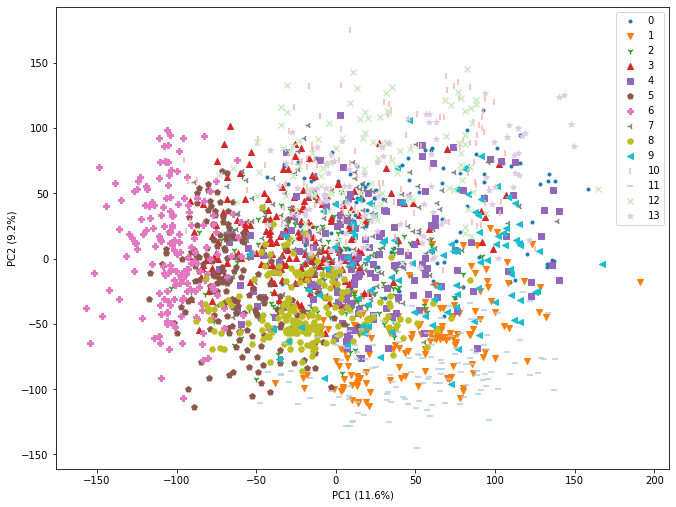


###### Original Data - Scaled ######


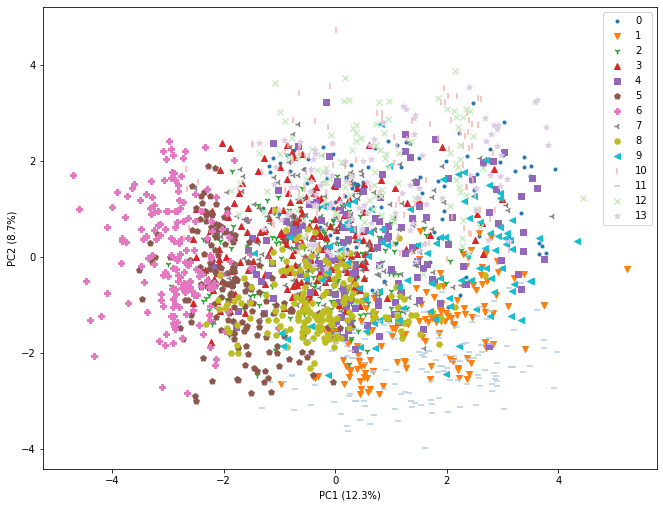


###### Reshaped Data - Unscaled #####


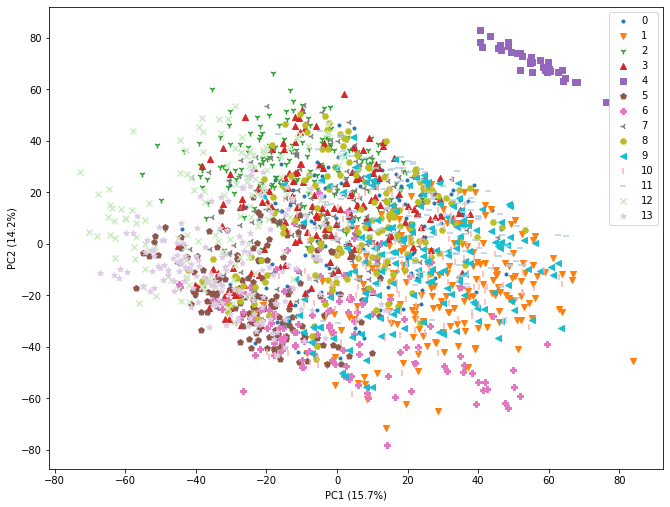


###### Reshaped Data - Scaled ######


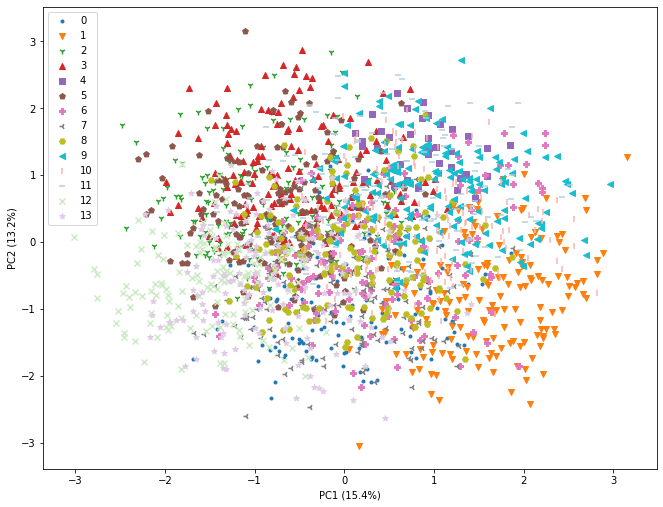

In [7]:
#your code here

print('\n###### Original Data - Unscaled #####')
plot_clusters(posture_processed, 'Cluster14', False)
print('\n###### Original Data - Scaled ######')
plot_clusters(posture_processed, 'Cluster14', True)


print('\n###### Reshaped Data - Unscaled #####')
plot_clusters(posture_reshaped, 'Cluster14', False)
print('\n###### Reshaped Data - Scaled ######')
plot_clusters(posture_reshaped, 'Cluster14', True)

your response here

(c) Plot the silhouette scores using the function below, from lecture. Give it a 10% sample of the data to speed the visualization. How reasonable does the clustering seem based on this plot? How does it compare to the information in the plot above?

In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


###### Original Data #####
For n_clusters = 14, the average silhouette_score is 0.06733128220447418.

###### Reshaped Data #####
For n_clusters = 14, the average silhouette_score is 0.11638734403483318.


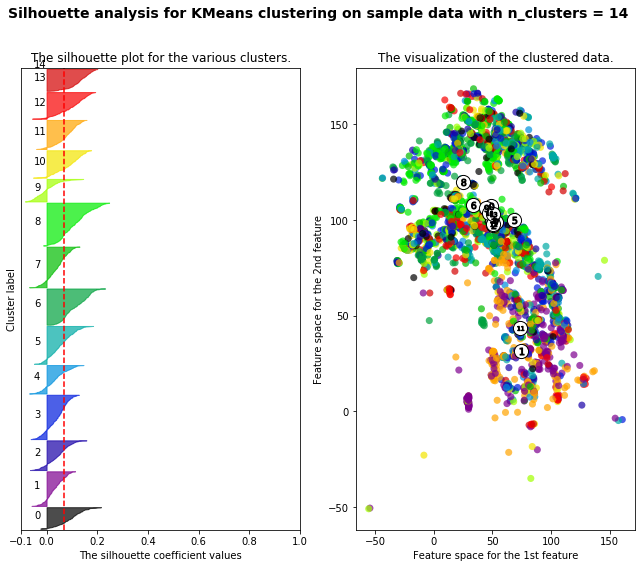

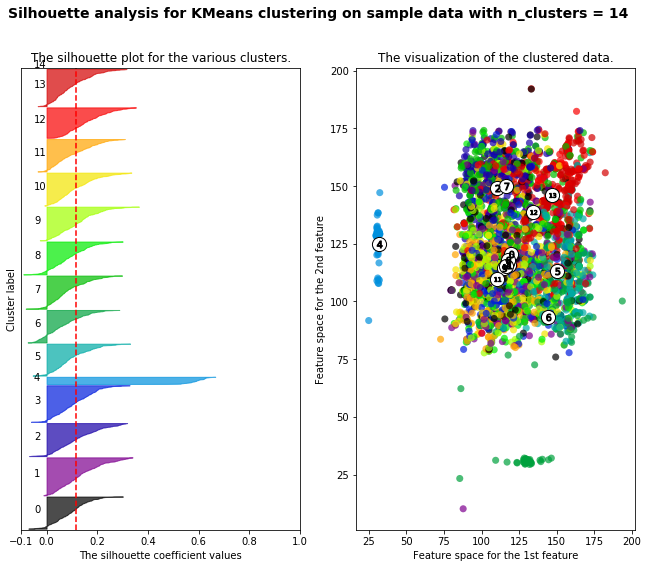

In [9]:
#your code here

X = posture_processed.sample(frac=0.1, random_state=109)
print('\n###### Original Data #####')
silplot(X.drop(['Cluster14'], axis = 1).to_numpy() , X.Cluster14.to_numpy(), 
        kmeans_user, pointlabels=None)

X = posture_reshaped.sample(frac=0.1, random_state=109)
print('\n###### Reshaped Data #####')
silplot(X.drop(['Cluster14'], axis = 1).to_numpy() , X.Cluster14.to_numpy(), 
        kmeans_user_reshaped, pointlabels=None)

your response here


(d) Repeat all of the above steps, but attempting to group by posture rather than by user. That is : 

(i) Run the k-means algorithm with 5 centroids instead of 14, creating a variable named `Cluster5` and adding it to the dataset. 

(ii) Visualize the results for k-means. Does 5 clusters seem to make sense from this plot?

(iii) Plot the silhouette scores on a 10% sample of the data. How reasonable does the clustering seem based on this plot?

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,Cluster14,Cluster5
0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,-55.674024,86.175444,...,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124,1,1
1,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,-55.975665,74.817984,...,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553,1,2
2,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,8.120352,52.961965,...,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279,13,4
3,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,1.064904,80.854870,...,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147,4,4
4,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,32.076937,95.211973,...,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243,0,3


,0,1,2,3,4,5,6,7,Cluster14,Cluster5
0,114.499695,86.849293,112.422397,133.424861,106.876536,95.093431,28.400211,91.999182,5,4
1,133.819095,106.629098,112.448931,114.133311,85.799561,94.780807,92.540167,27.662672,12,4
2,86.284872,106.249677,26.438164,112.085250,113.774150,133.508419,91.330517,94.718957,11,1
3,117.747130,165.102786,165.589721,123.858345,141.469322,96.498970,100.398851,174.143181,0,3
4,123.892598,117.751703,165.127062,141.440150,96.451575,139.064124,165.707672,108.289667,8,0



###### Original Data - Unscaled #####


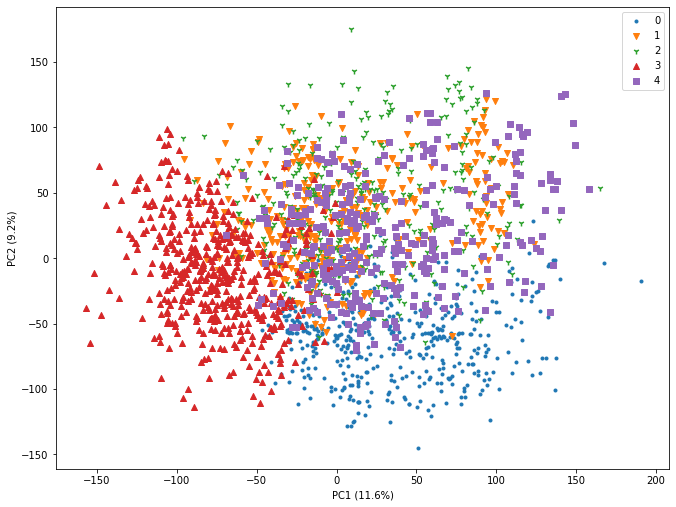


###### Original Data - Scaled ######


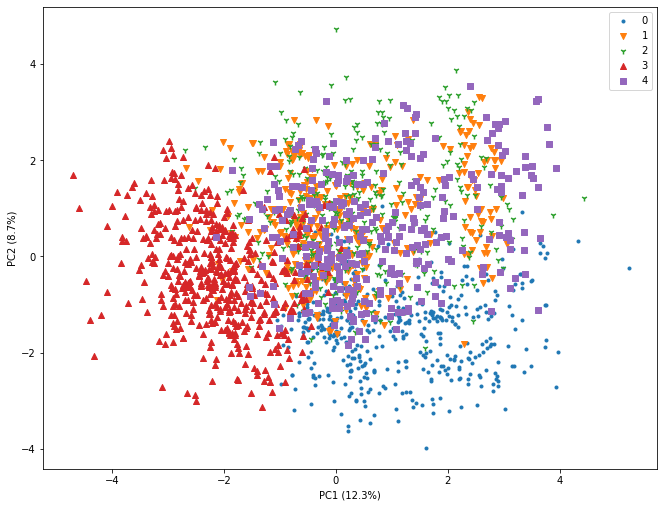


###### Reshaped Data - Unscaled #####


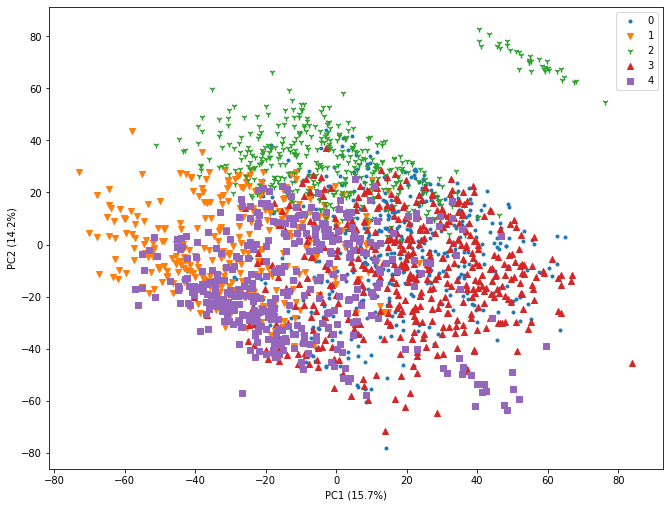


###### Reshaped Data - Scaled ######


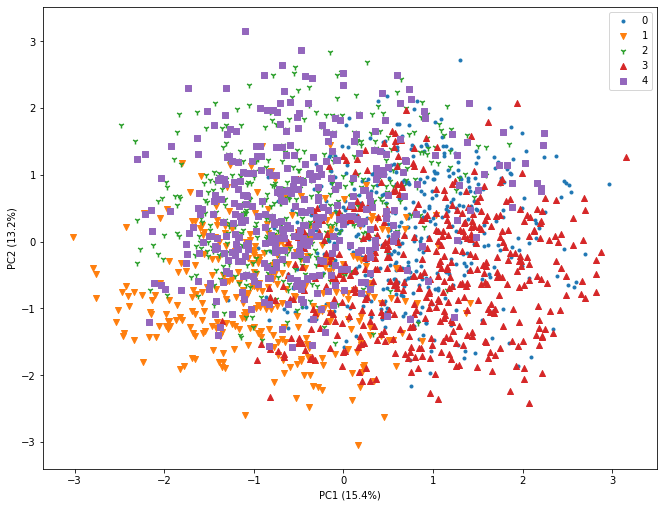

In [10]:
#your code here

kmeans_class = KMeans(n_clusters=postures.Class.unique().shape[0], n_init=46, random_state=109).fit(posture_processed)
posture_processed['Cluster5'] = kmeans_class.predict(posture_processed)
display(posture_processed.head())

kmeans_class_reshaped = KMeans(n_clusters=postures.Class.unique().shape[0], n_init=46, random_state=109).fit(posture_reshaped)
posture_reshaped['Cluster5'] = kmeans_class_reshaped.predict(posture_reshaped)
display(posture_reshaped.head())


print('\n###### Original Data - Unscaled #####')
plot_clusters(posture_processed, 'Cluster5', False)
print('\n###### Original Data - Scaled ######')
plot_clusters(posture_processed, 'Cluster5', True)


print('\n###### Reshaped Data - Unscaled #####')
plot_clusters(posture_reshaped, 'Cluster5', False)
print('\n###### Reshaped Data - Scaled ######')
plot_clusters(posture_reshaped, 'Cluster5', True)

your response here



###### Original Data #####
For n_clusters = 5, the average silhouette_score is 0.06988149900194666.

###### Reshaped Data #####
For n_clusters = 5, the average silhouette_score is 0.09213630872146122.


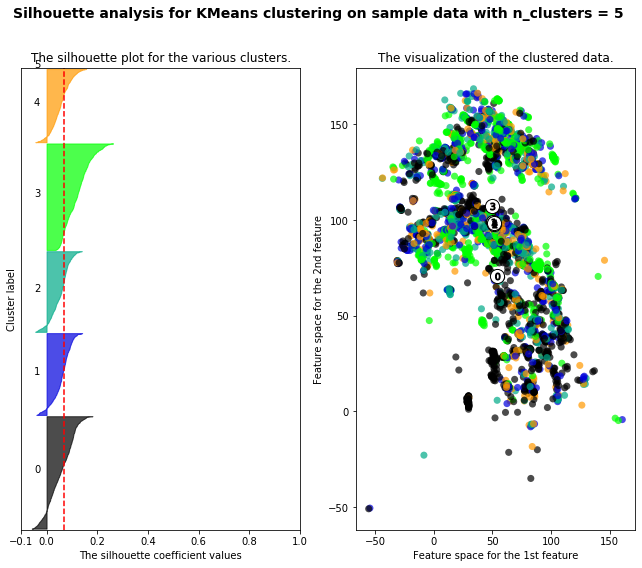

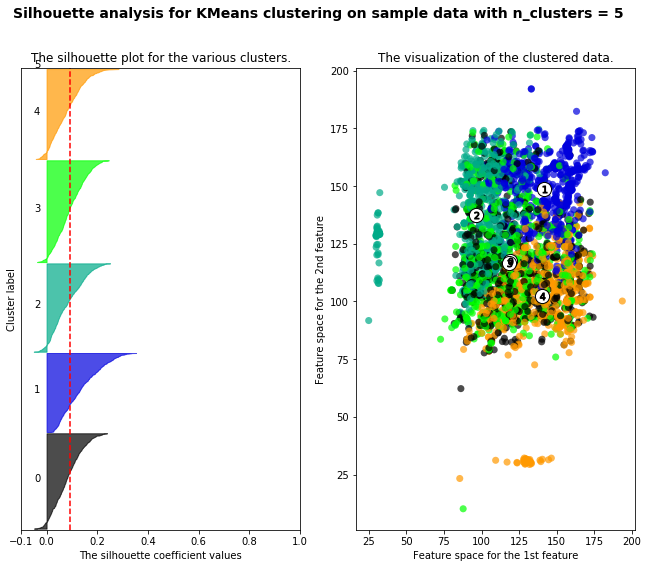

In [11]:
#your code here

X = posture_processed.sample(frac=0.1, random_state=109)
print('\n###### Original Data #####')
silplot(X.drop(['Cluster14', 'Cluster5'], axis = 1).to_numpy() , X.Cluster5.to_numpy(), 
        kmeans_class, pointlabels=None)


X = posture_reshaped.sample(frac=0.1, random_state=109)
print('\n###### Reshaped Data #####')
silplot(X.drop(['Cluster14', 'Cluster5'], axis = 1).to_numpy() , X.Cluster5.to_numpy(), 
        kmeans_class_reshaped, pointlabels=None)

your response here


(e) What do the results suggest? Does this make sense in the context of what we know about the problem?

your response here

<div class='exercise'> <b> Problem 2: Other Ks  </b> </div>

In the previous problem, we examined the results of running k-means with 5 and 14 centroids on the postures data. In this problem, we will investigate a broader range of possible cluster sizes, with a borader range of metrics. 

**For all of these questions, you should work with a sample of 2,000 data points drawn with `pd.sample` and a random seed of 109.**

(a) Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,15\}.$
 

In [12]:
#your code here

inertia = []
K = list(range(1,16))
sample_df = posture_processed.sample(2000, random_state=109).drop(['Cluster14', 'Cluster5'], axis=1)
for k in K:
    kmean = KMeans(n_clusters=k, n_init=46, random_state=109).fit(sample_df)
    inertia.append(kmean.inertia_)
k_means = pd.DataFrame({'k': K, 'inertia': inertia})


inertia_reshaped = []
K = list(range(1,16))
sample_df = posture_reshaped.sample(2000, random_state=109).drop(['Cluster14', 'Cluster5'], axis=1)
for k in K:
    kmean = KMeans(n_clusters=k, n_init=46, random_state=109).fit(sample_df)
    inertia_reshaped.append(kmean.inertia_)
k_means_reshaped = pd.DataFrame({'k': K, 'inertia': inertia})

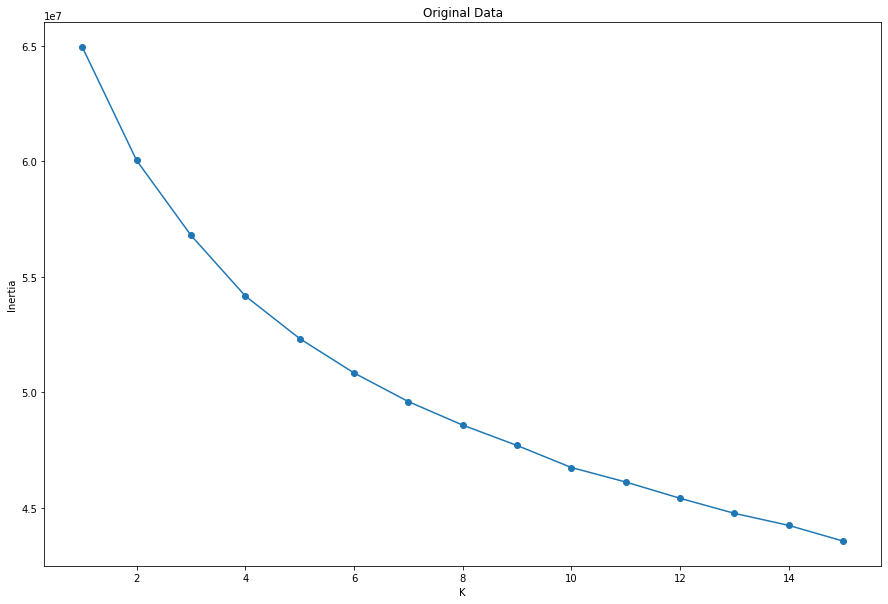

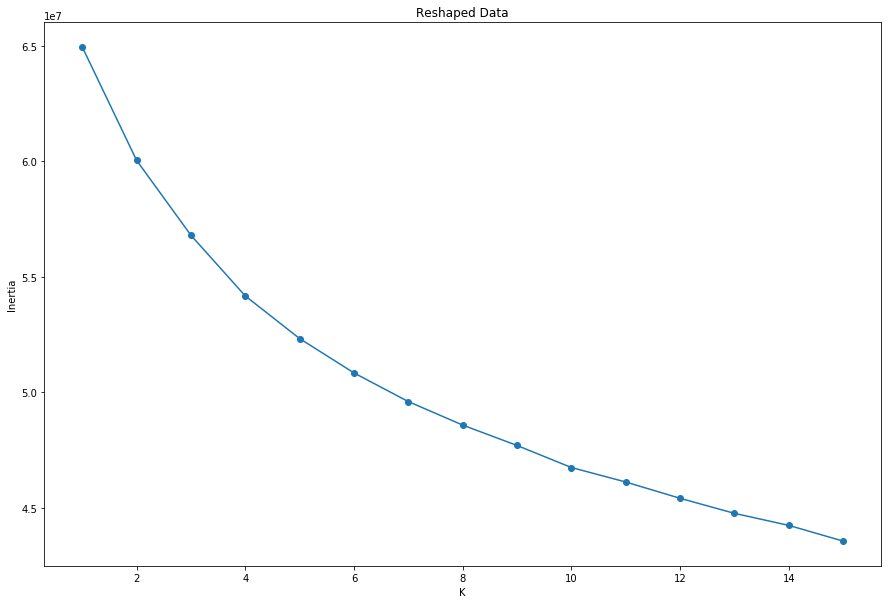

In [13]:
plt.figure(figsize=(15,10))
plt.plot(k_means.k, k_means.inertia, '-o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title('Original Data')
plt.show()


plt.figure(figsize=(15,10))
plt.plot(k_means_reshaped.k, k_means_reshaped.inertia, '-o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title('Reshaped Data')
plt.show()

(b) Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,15\}$. Plot the results. 

In [14]:
#your code here

X = posture_processed.sample(2000, random_state=109).drop(['Cluster14', 'Cluster5'], axis=1)
silhouette = [0]
K = list(range(1,16))
for k in range(2,16):
    kmean = KMeans(n_clusters=k, n_init=46, random_state=109).fit(X)
    cluster_labels = kmean.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette.append(silhouette_avg)
k_means_silh = pd.DataFrame({'k': K, 'silhouette score': silhouette})


X = posture_reshaped.sample(2000, random_state=109).drop(['Cluster14', 'Cluster5'], axis=1)
silhouette = [0]
for k in range(2,16):
    kmean = KMeans(n_clusters=k, n_init=46, random_state=109).fit(X)
    cluster_labels = kmean.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette.append(silhouette_avg)
k_means_silh_reshaped = pd.DataFrame({'k': K, 'silhouette score': silhouette})

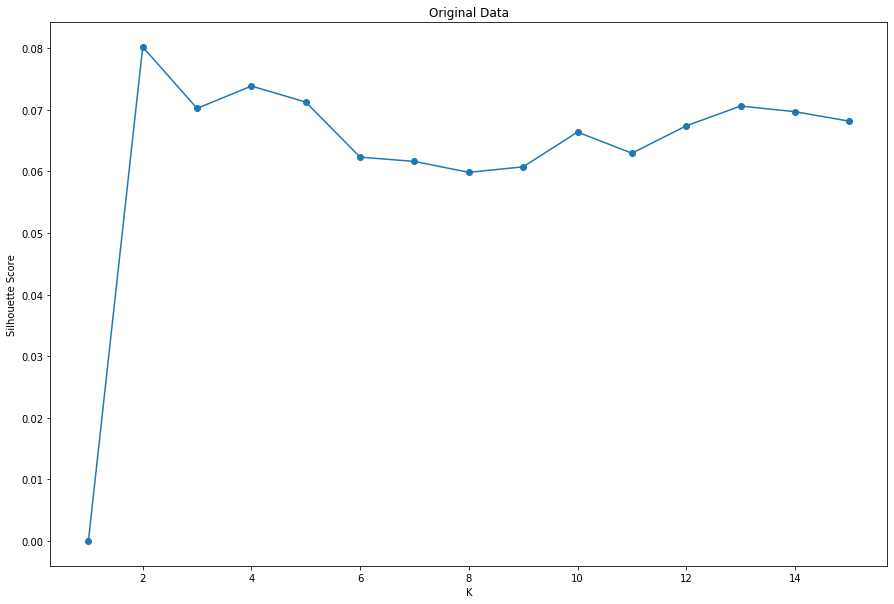

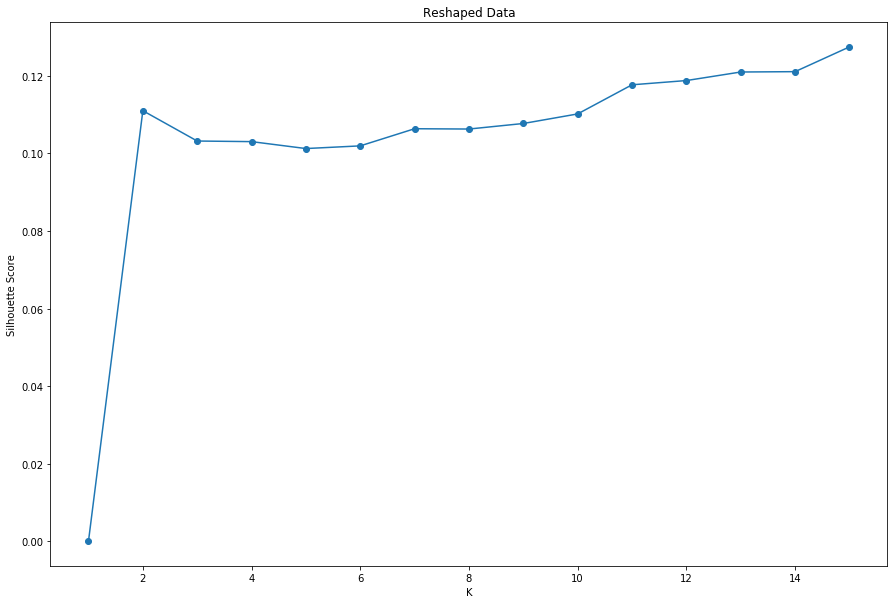

In [15]:
plt.figure(figsize=(15,10))
plt.plot(k_means_silh.k, k_means_silh['silhouette score'], '-o')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title('Original Data')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(k_means_silh_reshaped.k, k_means_silh_reshaped['silhouette score'], '-o')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title('Reshaped Data')
plt.show()

(c) Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Plot the results. 

Original Data - Optimal clusters:  15


,n_clusters,gap_value,gap*,ref_dispersion_std,diff,diff*
0,1.0,-9.704082,-1.275818e+09,66.448482,-0.050546,1.093486e+09
1,2.0,-9.652456,-1.178787e+09,80.941633,-0.033405,1.066491e+09
2,3.0,-9.618202,-1.117081e+09,62.422898,-0.027675,1.030571e+09
3,4.0,-9.589532,-1.068510e+09,72.086648,-0.020528,1.006992e+09
4,5.0,-9.567897,-1.032613e+09,79.154096,-0.009208,9.986325e+08


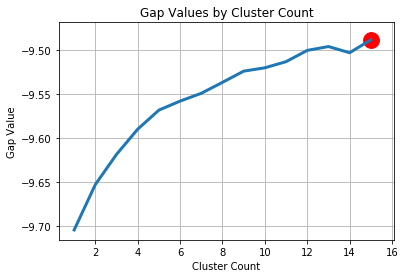

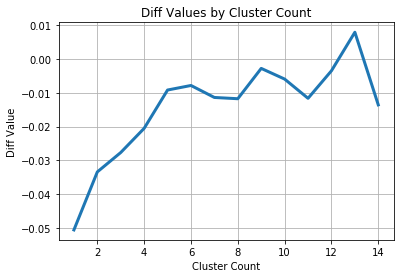

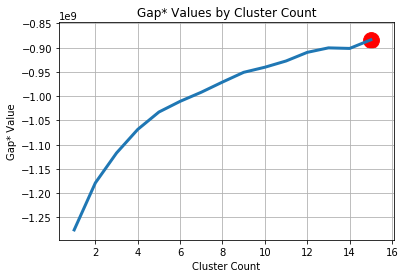

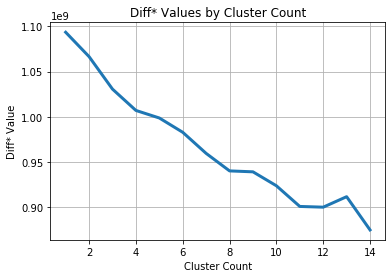

/usr/share/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Reshaped Data - Optimal clusters:  14


,n_clusters,gap_value,gap*,ref_dispersion_std,diff,diff*
0,1.0,-8.891100,-1.886768e+08,36.586839,-0.012597,1.504693e+08
1,2.0,-8.873872,-1.687335e+08,108.495949,-0.014138,1.441706e+08
2,3.0,-8.855964,-1.556775e+08,82.907334,-0.004193,1.387349e+08
3,4.0,-8.848282,-1.464775e+08,72.706955,0.005342,1.359481e+08
4,5.0,-8.851073,-1.405137e+08,50.840985,0.003022,1.308097e+08


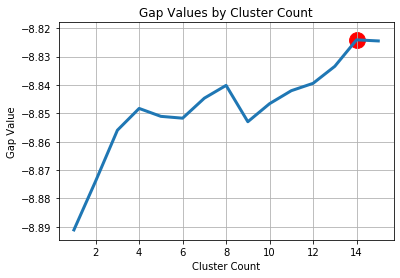

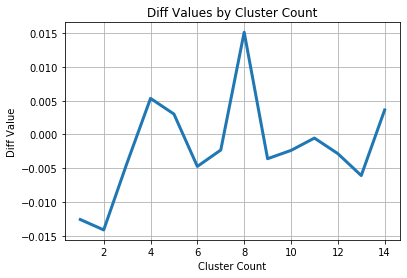

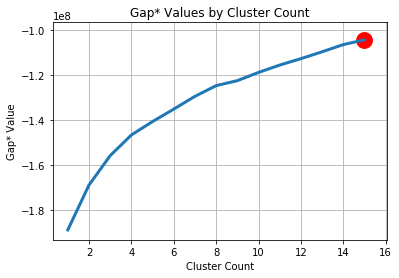

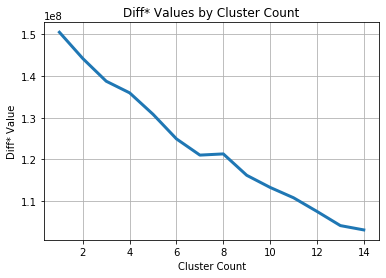

In [16]:
#your code here

gs_obj = OptimalK()
X = posture_processed.drop(['Cluster14', 'Cluster5'], axis=1).values
n_clusters = gs_obj(X, n_refs=50, cluster_array=np.arange(1, 16))
print('Original Data - Optimal clusters: ', n_clusters)
display(gs_obj.gap_df.head())
gs_obj.plot_results()


gs_obj_reshaped = OptimalK()
X_reshaped = posture_reshaped.drop(['Cluster14', 'Cluster5'], axis=1).values
n_clusters = gs_obj_reshaped(X_reshaped, n_refs=50, cluster_array=np.arange(1, 16))
print('Reshaped Data - Optimal clusters: ', n_clusters)
display(gs_obj_reshaped.gap_df.head())
gs_obj_reshaped.plot_results()

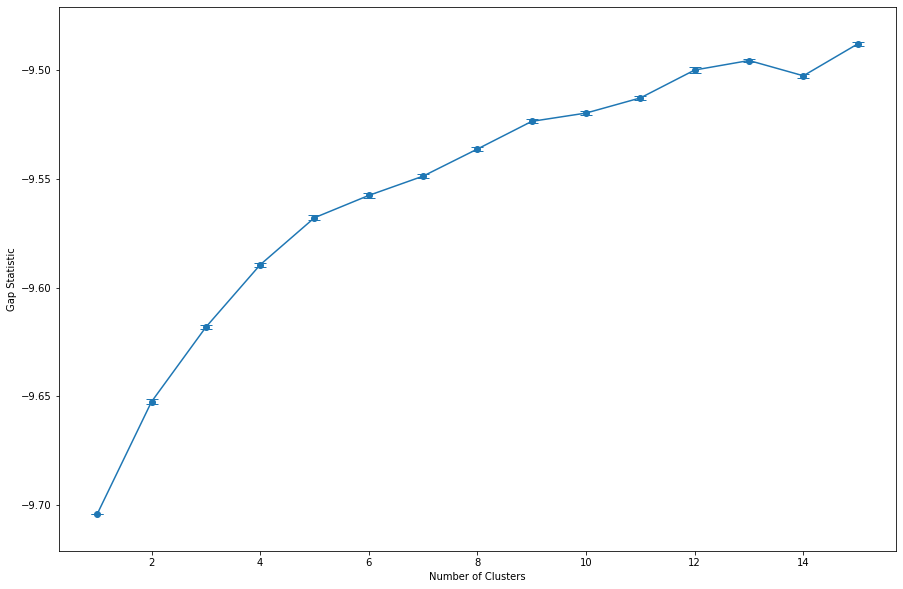

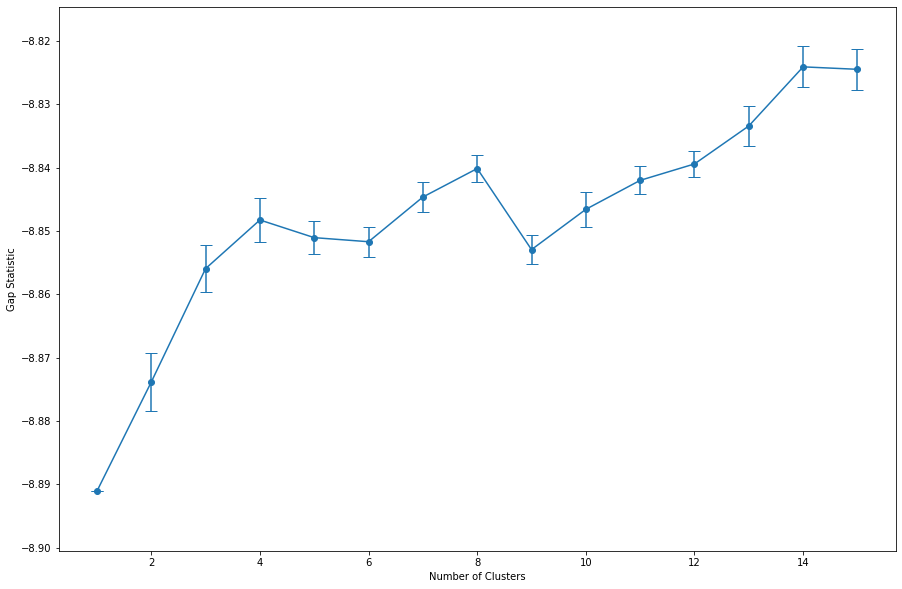

In [17]:
def display_gapstat_with_errbars(gap_df):
    gaps = gap_df["gap_value"].values
    diffs = gap_df["diff"]
    
    err_bars = np.zeros(len(gap_df))
    err_bars[1:] = diffs[:-1] - gaps[:-1] + gaps[1:]
    
    plt.figure(figsize=(15,10))
    plt.scatter(gap_df["n_clusters"], gap_df["gap_value"])
    plt.errorbar(gap_df["n_clusters"], gap_df["gap_value"], yerr=err_bars, capsize=6)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Gap Statistic")
    plt.show()
    
display_gapstat_with_errbars(gs_obj.gap_df)
display_gapstat_with_errbars(gs_obj_reshaped.gap_df)

(d) After analyzing the plots produced by all three of these measures, discuss the number of k-means clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you surmise about this dataset.

your response here


<div class='exercise'> <b> Problem 3: Alternative Algorithms  </b> </div>

(e) Run DBSCAN on the data. How many clusters are found, and how well does this clustering perform on e.g. silhouette score, excluding the points not assigned to any cluster?  
*Note*: Do not use a sample of the data. Running the algorithm may take up to 5-10 minutes.

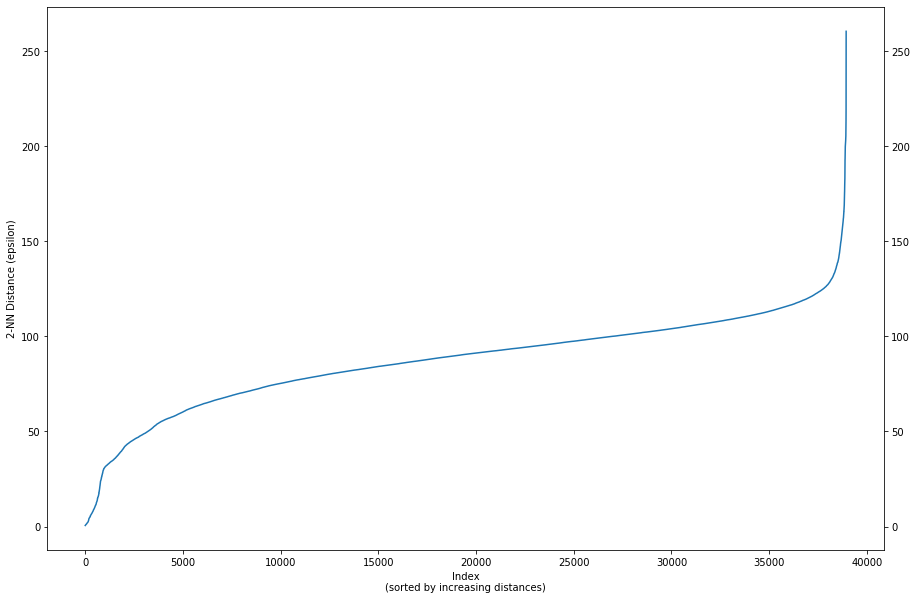

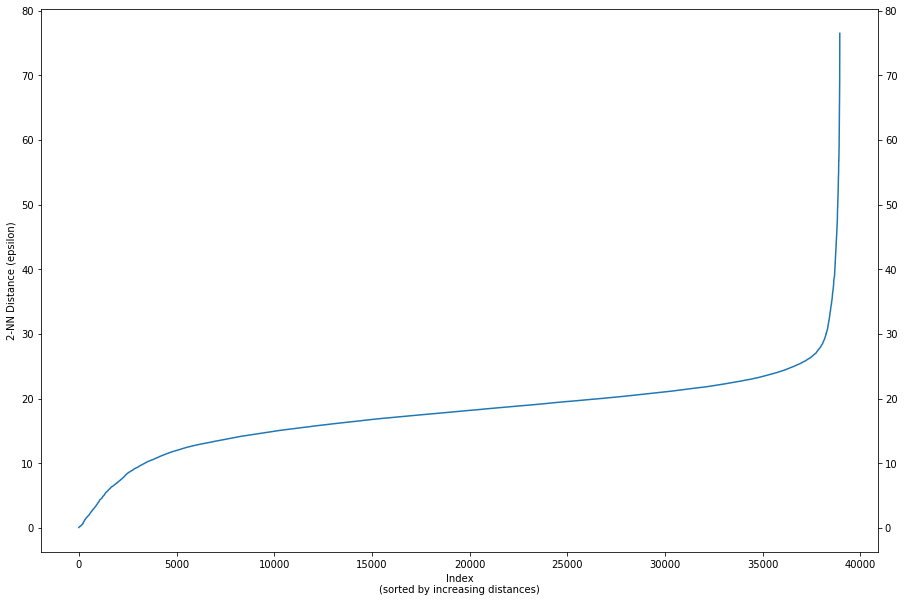

In [18]:
#your code here
from sklearn.neighbors import NearestNeighbors

def plot_epsilon(df, min_samples):

    fitted_neigbors = NearestNeighbors(n_neighbors=min_samples).fit(df)
    distances, indices = fitted_neigbors.kneighbors(df)
    
    dist_to_nth_nearest_neighbor = distances[:,-1]
    plt.figure(figsize=(15,10))
    plt.plot(np.sort(dist_to_nth_nearest_neighbor))
    plt.xlabel("Index\n(sorted by increasing distances)")
    plt.ylabel("{}-NN Distance (epsilon)".format(min_samples-1))
    plt.tick_params(right=True, labelright=True)
    plt.show()

plot_epsilon(X, 3)
plot_epsilon(X_reshaped, 3)

In [19]:
dbscan = DBSCAN(eps=125, min_samples=48, n_jobs=-1).fit(X)
dbscan_reshaped = DBSCAN(eps=25, min_samples=16, n_jobs=-1).fit(X_reshaped)

In [20]:
print('\n###### Original Data #####')
print(np.unique(dbscan.labels_))
print('Silhouette Score = {}'.format(silhouette_score(X[dbscan.labels_>=-1,], dbscan.labels_[dbscan.labels_>=-1])))


print('\n###### Reshaped Data #####')
print(np.unique(dbscan_reshaped.labels_))
print('Silhouette Score = {}'.format(silhouette_score(X_reshaped[dbscan_reshaped.labels_>=-1,], 
                                                      dbscan_reshaped.labels_[dbscan_reshaped.labels_>=-1])))


###### Original Data #####
[-1  0  1  2  3  4  5]
Silhouette Score = -0.026806180151458563

###### Reshaped Data #####
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]
Silhouette Score = -0.31493280209943386


(f) Hierarchical clustering. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results, and describe the cluster size(s) the plot suggests. What level of aggregation is suggested by the sihoutte score?


###### Cluster vs Class (K=4) ######


col_0,1,2,3,4
Class,,,,
1,0,1,0,1
2,153,315,126,161
3,66,7,30,91
4,106,8,37,119
5,153,86,395,145


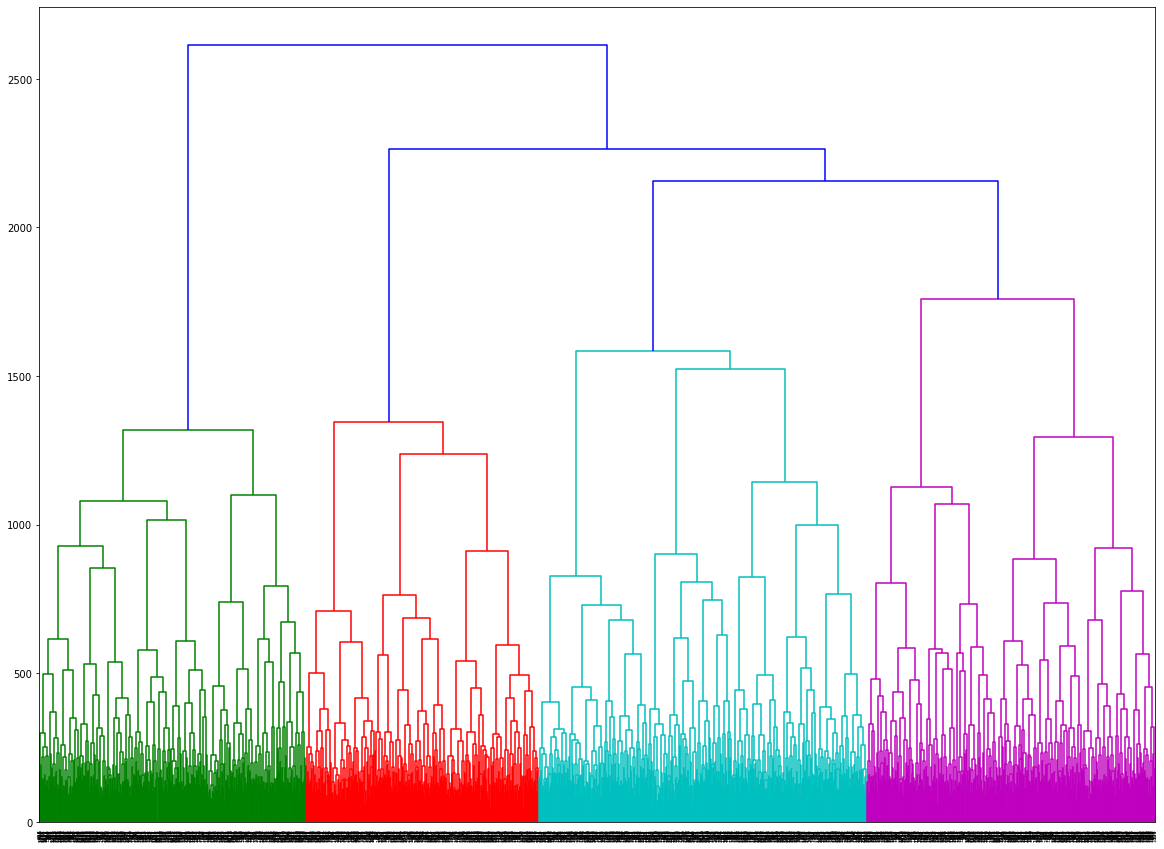

In [6]:
#your code here

from scipy.cluster.hierarchy import fcluster

X = postures.sample(2000, random_state=109)
y = X['Class']
z = X['User']
X = X.drop(['Class', 'User'], axis=1)
dist_mat = pdist(X, metric="euclidean")
ward_data = hac.ward(dist_mat)
plt.figure(figsize=(20,15))
hac.dendrogram(ward_data);

print('\n###### Cluster vs Class (K=4) ######')
display(pd.crosstab(y, fcluster(ward_data, 4, criterion='maxclust')))

your response here

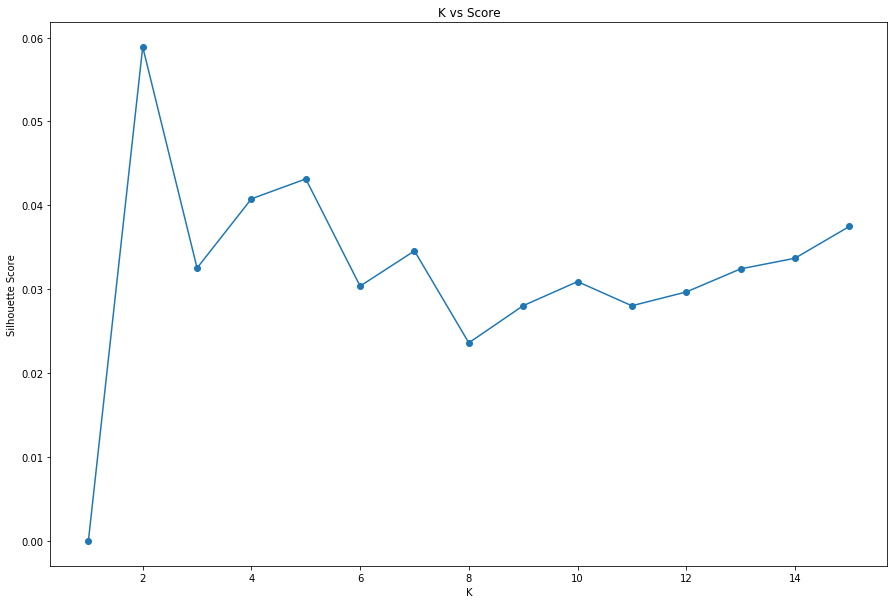


###### Cluster vs Class (K=2) ######


col_0,1,2
Class,,
1,0,2
2,153,602
3,66,128
4,106,164
5,153,626



###### Cluster vs Class (K=4) ######


col_0,1,2,3,4
Class,,,,
1,0,1,0,1
2,153,315,126,161
3,66,7,30,91
4,106,8,37,119
5,153,86,395,145



###### Cluster vs Class (K=5) ######


col_0,1,2,3,4,5
Class,,,,,
1,0,1,0,0,1
2,153,315,126,59,102
3,66,7,30,55,36
4,106,8,37,68,51
5,153,86,395,53,92



###### Cluster vs User (K=14) ######


col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
User,,,,,,,,,,,,,,
0,11,5,3,4,6,6,18,58,6,28,4,8,16,13
1,17,7,25,2,12,1,11,4,1,5,7,10,7,6
2,15,2,3,8,14,2,1,1,18,13,9,6,16,5
4,0,0,0,0,0,0,0,0,0,0,0,2,0,0
5,19,22,1,23,6,18,5,0,4,8,11,5,15,13
6,47,1,13,7,8,2,5,0,1,7,19,9,11,24
7,0,0,0,0,0,0,0,1,0,1,0,2,0,0
8,23,7,6,13,4,8,5,7,11,18,8,9,10,14
9,25,6,8,5,11,0,33,7,6,13,7,14,17,8


In [9]:
#your code here

silhouette = [0]
K = list(range(1,16))
for k in range(2,16):
    silhouette_avg = silhouette_score(X.values, fcluster(ward_data, k, criterion='maxclust'))
    silhouette.append(silhouette_avg)
ward_silh = pd.DataFrame({'k': K, 'silhouette score': silhouette})

plt.figure(figsize=(15,10))
plt.plot(ward_silh.k, ward_silh['silhouette score'], '-o')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title('K vs Score')
plt.show()

print('\n###### Cluster vs Class (K=2) ######')
display(pd.crosstab(y, fcluster(ward_data, 2, criterion='maxclust')))

print('\n###### Cluster vs Class (K=4) ######')
display(pd.crosstab(y, fcluster(ward_data, 4, criterion='maxclust')))

print('\n###### Cluster vs Class (K=5) ######')
display(pd.crosstab(y, fcluster(ward_data, 5, criterion='maxclust')))

print('\n###### Cluster vs User (K=14) ######')
display(pd.crosstab(z, fcluster(ward_data, 14, criterion='maxclust')))

your response here

(g) Overall, what do you conclude about the number and kind of clusters in this data set?

your response here
